#### Download, extract and copy the mash executable file to ./mash

In [ ]:
!wget https://github.com/marbl/Mash/releases/download/v2.2/mash-Linux64-v2.2.tar

In [ ]:
!tar -xf mash-Linux64-v2.2.tar

In [9]:
!cp mash-Linux64-v2.2/mash .
!rm -rf mash-Linux64-v2.2.tar mash-Linux64-v2.2

#### Benchmark

In [7]:
%run ../../multibench.py

In [8]:
import sys
import os
import shutil
import numpy as np
import glob

# Move two upper directories, import benchmark, revert cwd
sys.path.append("../..")
import cmdbench
sys.path.pop()

# Summarize numpy array if it has more than 10 elements
np.set_printoptions(threshold=10)

input_dir = 'input/'
input_samples = glob.glob(input_dir + '*.fastq.gz')
print(input_samples)

['input/2014C-3655_2.fastq.gz', 'input/2014C-3907_2.fastq.gz', 'input/2014C-3599_1.fastq.gz', 'input/2014C-3656_1.fastq.gz', 'input/2014C-3598_2.fastq.gz', 'input/2014C-3840_1.fastq.gz', 'input/2014C-3655_1.fastq.gz', 'input/2014C-3599_2.fastq.gz', 'input/2014C-3857_2.fastq.gz', 'input/2014C-3598_1.fastq.gz', 'input/2014C-3850_1.fastq.gz', 'input/2014C-3840_2.fastq.gz', 'input/2014C-3857_1.fastq.gz', 'input/2014C-3656_2.fastq.gz', 'input/2014C-3907_1.fastq.gz', 'input/2014C-3850_2.fastq.gz', 'input/2014C-3600_2.fastq.gz', 'input/2014C-3600_1.fastq.gz']


In [9]:
def clean_if_exists(path):
    if os.path.exists(path):
        if(os.path.isfile(path)):
            os.remove(path)
        else:
            shutil.rmtree(path)
            os.mkdir(path)
def get_last_n_lines(string, n):
    return "\n".join(string.split("\n")[-n:])

In [10]:
%%bash
# You might need to run this before starting jupyter notebook in your shell
export BIGSI_CONFIG=berkleydb.yaml

In [11]:
sample_sizes = list(range(1, 18 + 1))
print(sample_sizes)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


In [12]:
def reset_func():
    # It's already being done in the get_sketching_command function but just
    # in case we change that function
    clean_if_exists("sketches.msh")
    pass
    
def benchmark_list_to_results(benchmark_firsts_list):
    return {
        "memory": max(list(map(lambda result: result.memory.max, benchmark_firsts_list))),
        "disk_read": max(list(map(lambda result: result.disk.read_chars, benchmark_firsts_list))),
        "disk_write": max(list(map(lambda result: result.disk.write_chars, benchmark_firsts_list))),
        "runtime": sum(list(map(lambda result: result.process.execution_time, benchmark_firsts_list)))
    }
def sampling_func(sample_size):
    samples = input_samples[:sample_size]
    return samples

sketching_command_run_count = 25

def get_sketching_command(inputs):
    clean_if_exists("sketches.msh")
    return "./mash sketch -o sketches.msh " + " ".join(inputs)
    
# Execute the same "get_sketching_command(...)" command "sketching_command_run_count" times
build_command = {
    "use_parallel": True,
    "command": get_sketching_command,
    "parallel_args": "-j 1 -N0 ",
    "parallel_argfiles": ["_"] * sketching_command_run_count
}

dist_calculation_times = 25
dist_calculating_genome = "2014C-3600_1.fastq.gz"

query_command = {
    "command": "./mash dist sketches.msh input/% ",
    "parallel_args": "-j 1 -I%",
    "parallel_argfiles": [dist_calculating_genome] * dist_calculation_times
}

multibench_results, debug_str = multi_cmdbench({
"index": [build_command],
"query": [query_command]
}, reset_func = reset_func, iterations = 10, sampling_func = sampling_func, sample_sizes = sample_sizes, 
    benchmark_list_to_results=benchmark_list_to_results)

In [21]:
# print(debug_str[-100000:])

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 15, 3

[{'memory': 28138291.2, 'disk_read': 5191680.6, 'disk_write': 2121730.4, 'runtime': 0.321}, {'memory': 28044492.8, 'disk_read': 8258159.3, 'disk_write': 2381723.6, 'runtime': 0.492}, {'memory': 28291891.2, 'disk_read': 12236921.2, 'disk_write': 2635215.2, 'runtime': 0.757}, {'memory': 28181708.8, 'disk_read': 14535271.1, 'disk_write': 2860223.1, 'runtime': 0.917}, {'memory': 28304588.8, 'disk_read': 19411743.4, 'disk_write': 3089127.1, 'runtime': 1.1819999999999997}, {'memory': 28314828.8, 'disk_read': 21806534.7, 'disk_write': 3311474.7, 'runtime': 1.337}, {'memory': 28168601.6, 'disk_read': 24478549.6, 'disk_write': 3528042.9, 'runtime': 1.5189999999999997}, {'memory': 27924889.6, 'disk_read': 29314592.8, 'disk_write': 3747031.4, 'runtime': 1.775}, {'memory': 28126003.2, 'disk_read': 32138257.0, 'disk_write': 3962002.9, 'runtime': 1.9489999999999998}, {'memory': 28123955.2, 'disk_read': 36162303.7, 'disk_write': 4184576.9, 'runtime': 2.219}, {'memory': 27723776.0, 'disk_read': 388416

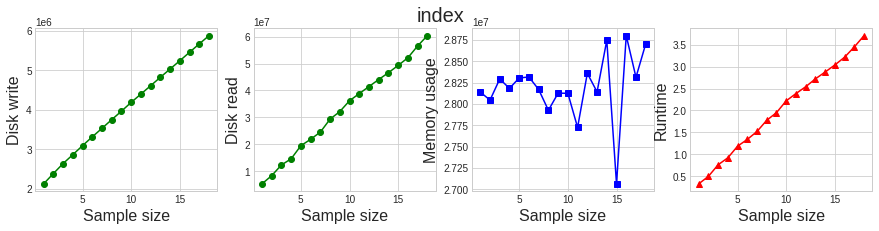

In [14]:
# Indexing Plots
plot_resources(multibench_results, sample_sizes, "index")

[{'memory': 27174912.0, 'disk_read': 6099766.6, 'disk_write': 1946786.7, 'runtime': 0.399}, {'memory': 28034252.8, 'disk_read': 6101773.9, 'disk_write': 1954306.9, 'runtime': 0.402}, {'memory': 28200960.0, 'disk_read': 6103949.0, 'disk_write': 1957761.8, 'runtime': 0.4090000000000001}, {'memory': 28067840.0, 'disk_read': 6106100.2, 'disk_write': 1966158.5, 'runtime': 0.41200000000000003}, {'memory': 28320972.8, 'disk_read': 6108232.5, 'disk_write': 1967172.5, 'runtime': 0.4080000000000001}, {'memory': 28235776.0, 'disk_read': 6110715.1, 'disk_write': 1971408.3, 'runtime': 0.4090000000000001}, {'memory': 28501606.4, 'disk_read': 6111987.7, 'disk_write': 1978870.6, 'runtime': 0.41200000000000003}, {'memory': 28042035.2, 'disk_read': 6113735.9, 'disk_write': 1982269.2, 'runtime': 0.41100000000000003}, {'memory': 28460646.4, 'disk_read': 6116391.9, 'disk_write': 1985795.3, 'runtime': 0.413}, {'memory': 28123955.2, 'disk_read': 6119403.1, 'disk_write': 1986022.0, 'runtime': 0.41000000000000

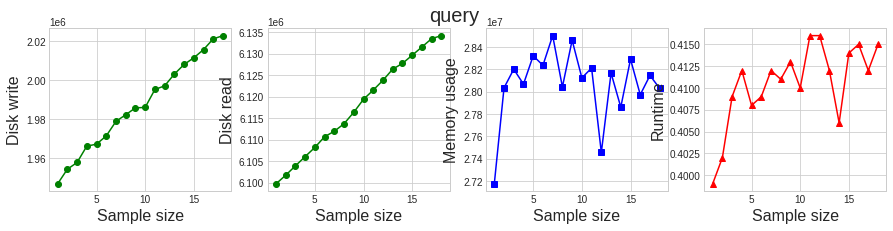

In [15]:
# Querying Plots
plot_resources(multibench_results, sample_sizes, "query")